# Oxford Weather Dataset

In [15]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
    create_test_oxford_run_data
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = create_test_oxford_run_data(data_path=base_dir / "data").to_xarray().rename({"sample": "station"})
ds

<xarray.Dataset>
Dimensions:        (station: 1, time: 996)
Coordinates:
  * time           (time) datetime64[ns] 1929-01-01 1929-02-01 ... 2011-12-01
  * station        (station) int64 1
Data variables:
    max_temp       (time, station) float64 3.7 3.3 12.9 11.8 ... 17.2 13.5 9.3
    min_temp       (time, station) float64 -1.1 -3.0 -0.1 2.5 ... 9.5 6.3 3.1
    frost_hrs      (time, station) int64 21 19 17 6 2 0 0 0 ... 0 0 0 0 0 0 1 4
    precipitation  (time, station) float64 29.8 14.1 1.4 34.3 ... 26.3 28.4 71.2
    sun_hrs        (time, station) float64 43.8 60.5 190.2 ... 130.6 64.8 62.6

# Load in config file

In [4]:
cfg = Config(base_dir / "tests/testconfigs/weather.yml")
cfg._cfg["n_epochs"] = 10
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 1
cfg._cfg["seq_length"] = 48
cfg

{'autoregressive': True,
 'batch_size': 256,
 'data_dir': PosixPath('data'),
 'experiment_name': 'oxford_weather',
 'hidden_size': 64,
 'horizon': 1,
 'input_variables': ['max_temp', 'precipitation', 'sun_hrs'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 10,
 'num_workers': 4,
 'optimizer': 'Adam',
 'pixel_dims': ['station'],
 'run_dir': None,
 'seed': 1234,
 'seq_length': 48,
 'target_variable': 'min_temp',
 'test_end_date': Timestamp('2015-12-31 00:00:00'),
 'test_start_date': Timestamp('2001-01-01 00:00:00'),
 'train_end_date': Timestamp('2000-12-31 00:00:00'),
 'train_start_date': Timestamp('1940-01-01 00:00:00'),
 'validation_end_date': Timestamp('1939-12-31 00:00:00'),
 'validation_start_date': Timestamp('1929-01-01 00:00:00')}

# Create trainer

In [5]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 213.22it/s]


In [6]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.73
Valid Loss: 0.33


Training Epoch 3:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.32
Valid Loss: 0.18


Training Epoch 4:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.20
Valid Loss: 0.27


Training Epoch 5:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.21
Valid Loss: 0.18


Training Epoch 6:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.19
Valid Loss: 0.15


Training Epoch 7:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.18
Valid Loss: 0.18


Training Epoch 8:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.17
Valid Loss: 0.14


Training Epoch 9:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.17
Valid Loss: 0.15


Training Epoch 10:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.17
Valid Loss: 0.15


Validation Epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Train Loss: 0.16
Valid Loss: 0.13


# Check losses of trained model

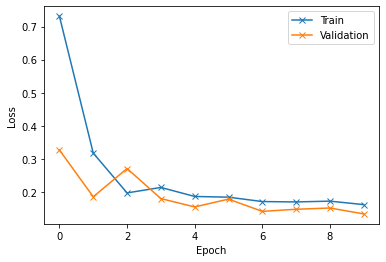

In [7]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Run Evaluation

In [8]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 219.78it/s]


Test set Forward Pass: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


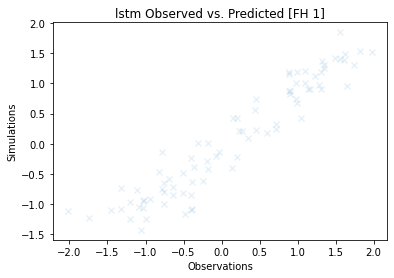

In [9]:
tester.run_test()

# The output forecasts! 

In [18]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
ds = xr.open_dataset(xr_path).isel(horizon=0, pixel=0).drop(["horizon", "pixel"])
ds

<xarray.Dataset>
Dimensions:  (time: 83)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-31T23:59:34.471303168 ... 2011-12-...
Data variables:
    sim      (time) float32 ...
    obs      (time) float32 ...

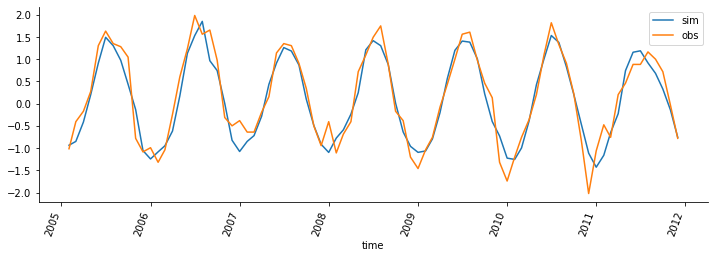

In [19]:
# .sel(time=slice("2015-01-01", "2015-02-01"))
f, ax = plt.subplots(figsize=(12, 4))
ds.isel(time=slice(0, 100)).to_dataframe().plot(ax=ax)
plt.xticks(rotation=70);
sns.despine()